In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gcsfs
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'pandas'

In [ ]:
datasets = ["2023-05"]
bucket_name = "prediswiss-parquet-data"

In [ ]:
fs_gcs = gcsfs.GCSFileSystem()
dataframes = []
for dataset in datasets:
    path = bucket_name + "/" + dataset + ".parquet"
    table = pq.read_table(path, filesystem=fs_gcs)
    df = table.to_pandas()
    dataframes.append(df)
df = pd.concat(dataframes)

In [ ]:
# Specify the parameters
id = 'CH:0542.05'
target = 'flow_11'
date = 'publication_date'

# Filter the DataFrame based on the specified id
filtered_df = df[df['id'] == id].copy()

filtered_df = filtered_df[[date, target]]
filtered_df = filtered_df.sort_values(date)
filtered_df[target] = pd.to_numeric(filtered_df[target], errors='coerce')
filtered_df[date] = pd.to_datetime(filtered_df[date])


In [ ]:
filtered_df['flow_11'].fillna(0, inplace=True)
filtered_df.isnull().sum()

publication_date    0
flow_11             0
dtype: int64

In [ ]:
filtered_df.reset_index(inplace=True)
filtered_df['index'] = filtered_df.index
filtered_df

,index,publication_date,flow_11
0,0,2023-05-10 10:57:18.254077+00:00,1380.0
1,1,2023-05-10 10:58:18.078285+00:00,1380.0
2,2,2023-05-10 10:59:18.203105+00:00,1260.0
3,3,2023-05-10 11:00:18.063256+00:00,1560.0
4,4,2023-05-10 11:01:18.162343+00:00,1620.0
...,...,...,...
29995,29995,2023-05-31 23:52:18.127738+00:00,120.0
29996,29996,2023-05-31 23:53:18.192065+00:00,60.0
29997,29997,2023-05-31 23:54:18.249585+00:00,120.0
29998,29998,2023-05-31 23:55:18.057492+00:00,0.0


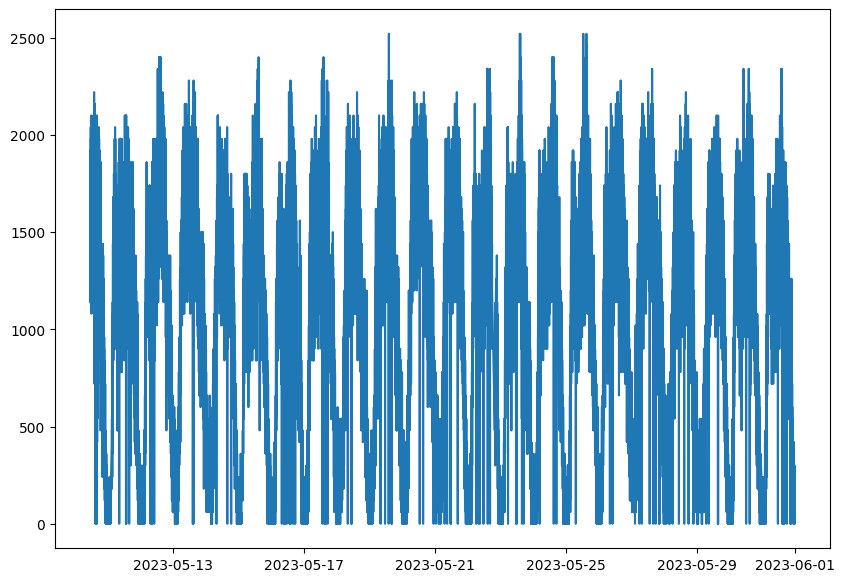

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(filtered_df['publication_date'], filtered_df['flow_11'])
plt.show()

In [ ]:
size = 60
train, test = train_test_split(filtered_df, test_size=size/len(filtered_df), shuffle=False)
train.tail()

,index,publication_date,flow_11
29935,29935,2023-05-31 22:52:18.214632+00:00,180.0
29936,29936,2023-05-31 22:53:18.029750+00:00,300.0
29937,29937,2023-05-31 22:54:18.084272+00:00,180.0
29938,29938,2023-05-31 22:55:18.162933+00:00,60.0
29939,29939,2023-05-31 22:56:18.235880+00:00,60.0


In [ ]:
test.head()

,index,publication_date,flow_11
29940,29940,2023-05-31 22:57:18.041246+00:00,60.0
29941,29941,2023-05-31 22:58:18.118149+00:00,60.0
29942,29942,2023-05-31 22:59:18.183638+00:00,420.0
29943,29943,2023-05-31 23:00:18.234286+00:00,240.0
29944,29944,2023-05-31 23:01:18.048370+00:00,180.0


In [ ]:
model = Prophet()
model.fit(train)

NameError: name 'Prophet' is not defined